<a href="https://colab.research.google.com/github/MahparaBadar/Deep-Learning/blob/main/Brain_Tumor_Detection_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


Copying files: 253 files [00:00, 4355.83 files/s]


Dataset ImageFolder
    Number of datapoints: 202
    Root location: /content/brain/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Loss in Iteration: 0 : 0.6851580739021301
Loss in Iteration: 1 : 0.7170401811599731
Loss in Iteration: 2 : 0.6818233132362366
Loss in Iteration: 3 : 0.6997792720794678
Epoch:0  Loss:0.6959502100944519  Accuracy:60.7843132019043%
Loss in Iteration: 0 : 0.6693139672279358
Loss in Iteration: 1 : 0.6819189190864563
Loss in Iteration: 2 : 0.6742082834243774
Loss in Iteration: 3 : 0.58857262134552
Epoch:1  Loss:0.6535034477710724  Accuracy:60.7843132019043%
Loss in Iteration

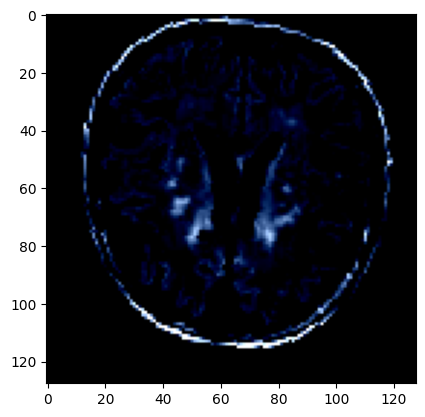

In [14]:
!pip install split-folders

# Install the kagglehub library if not already installed
import kagglehub

# Import necessary libraries
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import pathlib
from torch import optim
import splitfolders

# Step 1: Download the dataset using kagglehub
# This library allows easy access to Kaggle datasets directly from Python
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

# Step 2: Print the path to verify the dataset location
print("Path to dataset files:", path)

# Step 3: Define the directory for the dataset
# The directory contains images of brain MRIs classified as 'yes' or 'no' for tumor presence
data_dir = os.path.join(path, "brain_tumor_dataset")
data_dir = pathlib.Path(data_dir)

# Step 4: Split the dataset into training and validation sets
# Use an 80-20 split ratio for training and validation
splitfolders.ratio(data_dir, output="brain", seed=41, ratio=(0.8, 0.2))

# Step 5: Update the data directory to the newly split dataset
data_dir = pathlib.Path("/content/brain")

# Step 6: Define transformations for the images
# These transformations include resizing, random flipping, rotation, normalization, etc.
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Apply random vertical flip
    transforms.RandomRotation(30),  # Apply random rotation up to 30 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Step 7: Create training and validation datasets
# Use the ImageFolder class to load images and apply transformations
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform)
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('val'), transform=transform)

# Step 8: Display details about the training dataset
# Print the dataset structure to verify the loading process
print(train_set)

# Visualize a sample image from the training dataset
# Select an image and its corresponding label for display
img, label = train_set[5]
plt.imshow(img.permute(1, 2, 0))

# Step 9: Define the data loaders for training and validation
# Use DataLoader to handle batches and parallel data loading
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)


# Define the Convolutional Neural Network (CNN) model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First convolutional layer
        self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)  # Output: 124x124
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # Output: 62x62

        # Second convolutional layer
        self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)  # Output: 58x58
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # Output: 29x29

        # Third convolutional layer
        self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)  # Output: 25x25
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)  # Output: 12x12

        # Fourth convolutional layer
        self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)  # Output: 8x8
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)  # Output: 4x4

        # Fifth convolutional layer
        self.cnv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)  # Output: 2x2
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)  # Output: 1x1

        # LeakyReLU activation function
        self.leakyRelu = nn.LeakyReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 1 * 1, 1024)  # Adjust input size for fully connected layers
        self.fc2 = nn.Linear(1024, 2)  # Output layer with 2 classes: 'tumor' and 'no tumor'

    def forward(self, x):
        # Apply each convolutional layer followed by activation and pooling
        out = self.leakyRelu(self.cnv1(x))
        out = self.maxpool1(out)

        out = self.leakyRelu(self.cnv2(out))
        out = self.maxpool2(out)

        out = self.leakyRelu(self.cnv3(out))
        out = self.maxpool3(out)

        out = self.leakyRelu(self.cnv4(out))
        out = self.maxpool4(out)

        out = self.leakyRelu(self.cnv5(out))
        out = self.maxpool5(out)

        # Flatten the output for fully connected layers
        out = out.view(out.size(0), -1)

        # Pass through fully connected layers
        out = self.leakyRelu(self.fc1(out))
        out = self.fc2(out)

        return out


# Training the CNN model
num_epochs = 30
model = CNNModel()
error = nn.CrossEntropyLoss()

# Define optimizer and learning rate scheduler
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Lists to store metrics during training
train_loss_list = []
val_loss_list = []
accuracy_list = []

# Training loop
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0

    # Training phase
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = error(outputs, labels)  # Calculate loss
        train_loss += loss.item()  # Accumulate training loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Print loss for each iteration
        print("Loss in Iteration:", i, ":", loss.item())

    # Validation phase
    total = 0
    correct = 0
    for images, labels in val_loader:
        outputs = model(images)  # Forward pass
        v_loss = error(outputs, labels)  # Calculate validation loss
        val_loss += v_loss.item()  # Accumulate validation loss
        predicted = torch.max(outputs.data, 1)[1]  # Get predictions

        # Calculate total and correct predictions
        total += len(labels)
        correct += (predicted == labels).sum()

    # Update learning rate based on validation loss
    scheduler.step(val_loss / len(val_loader))
    accuracy = 100 * correct / float(total)

    # Append metrics for plotting
    train_loss_list.append(train_loss / len(train_loader))
    val_loss_list.append(val_loss / len(val_loader))
    accuracy_list.append(accuracy)

    # Print metrics for each epoch
    print("Epoch:{}  Loss:{}  Accuracy:{}%".format(epoch, train_loss / len(train_loader), accuracy))

# # Plot training and validation losses
# plt.plot(range(num_epochs), train_loss_list, label="Training Loss")
# plt.plot(range(num_epochs), val_loss_list, label="Validation Loss")
# plt.legend()
# plt.show()

# # Plot accuracy
# plt.plot(range(num_epochs), accuracy_list, label="Accuracy")
# plt.legend()
# plt.show()

# # Test the model with a sample image from the validation set
# img, label = val_set[5]
# plt.imshow(img.permute(1, 2, 0))
# plt.title(label)
# image = img.unsqueeze(0)

# with torch.no_grad():
#     output = model(image)

# _, pred = torch.max(output, 1)
# print("Predicted Output:", pred.item())


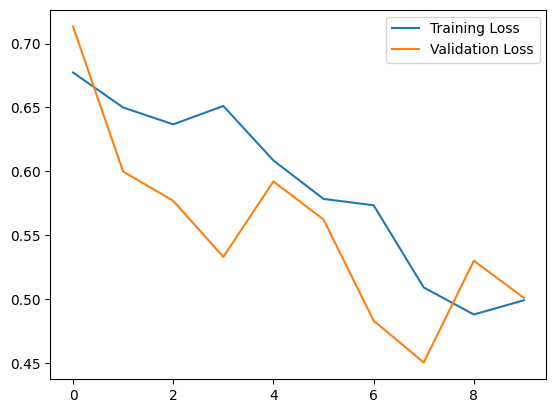

In [10]:
# Plot training and validation losses
plt.plot(range(num_epochs), train_loss_list, label="Training Loss")
plt.plot(range(num_epochs), val_loss_list, label="Validation Loss")
plt.legend()
plt.show()

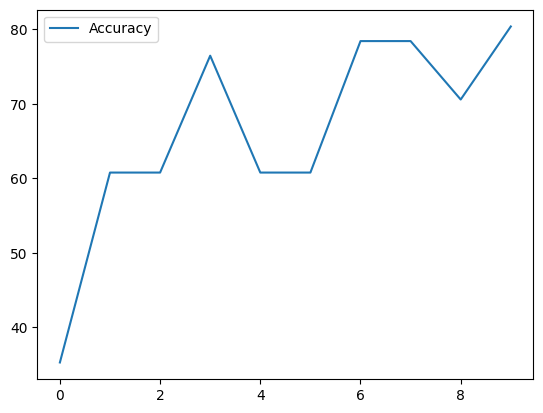

In [11]:
# Plot accuracy
plt.plot(range(num_epochs), accuracy_list, label="Accuracy")
plt.legend()
plt.show()

Predicted Output: 0


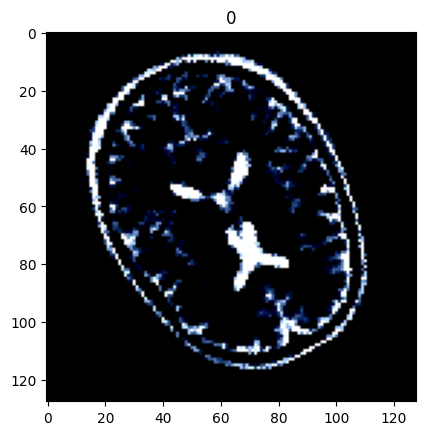

In [12]:
# Test the model with a sample image from the validation set
img, label = val_set[5]
plt.imshow(img.permute(1, 2, 0))
plt.title(label)
image = img.unsqueeze(0)

with torch.no_grad():
    output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())